# Imports

In [10]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration's

In [11]:
# =====================
# CONFIGURATION
# =====================
config = {
    "model": "dct",   # Options: mobilenetv2, convnext, dct, stft, wavelet, learnable_freq
    "epochs": 60,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 7,
    "dropout": 0.4,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
}
config["save_dir"] = os.path.join("models", config["model"])
os.makedirs(config["save_dir"], exist_ok=True)

config["model_path_auc"] = os.path.join(config["save_dir"], "best_auc.pth")
config["model_path_loss"] = os.path.join(config["save_dir"], "best_loss.pth")
print(f"Models will be saved in: {config['model_path_auc']}")
print(f"Models will be saved in: {config['model_path_loss']}")

Models will be saved in: models\dct\best_auc.pth
Models will be saved in: models\dct\best_loss.pth


# Transformation and DataLoader

In [12]:
# =====================
# DATA PIPELINE
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(config["train_dir"], transform=transform)
val_data = datasets.ImageFolder(config["val_dir"], transform=transform)
test_data = datasets.ImageFolder(config["test_dir"], transform=transform)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False)

# =====================
# DEVICE
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}" + (f" - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

Using device: cuda - NVIDIA GeForce RTX 3050 Laptop GPU


# Model Builder

In [13]:
# =====================
# MODEL BUILDER
# =====================
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def build_model(config):
    if config["model"] == "mobilenetv2":
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        in_features = base.classifier[1].in_features
        base.classifier = ClassifierHead(in_features, config["num_classes"], config["dropout"])
        return base

    elif config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base

    elif config["model"] == "dct":
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(512, config["num_classes"])
        )

    elif config["model"] == "stft":
        return nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, config["num_classes"])
        )

    elif config["model"] == "wavelet":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    elif config["model"] == "learnable_freq":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    else:
        raise ValueError(f"Unknown model type: {config['model']}")

model = build_model(config).to(device)

# =====================
# TRAINING SETUP
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Helper Function's

In [14]:
# =====================
# HELPER FUNCTIONS
# =====================
def compute_metrics(y_true, y_pred, y_prob, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# Training and Validation

In [15]:
best_val_loss = np.inf
best_val_auc = -np.inf
patience_counter = 0

# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

# Adding SEED 
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =====================
# TRAINING LOOP
# =====================
for epoch in range(config["epochs"]):
    # -------- TRAIN --------
    model.train()
    train_loss, train_preds, train_labels, train_probs = 0, [], [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        train_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(probs.cpu().detach().numpy())

    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(
        train_labels, train_preds, train_probs
    )

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels, val_probs = 0, [], [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]"):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            probs = torch.softmax(preds, dim=1)
            val_preds.extend(torch.argmax(preds, 1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1, val_auc = compute_metrics(
        val_labels, val_preds, val_probs
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    # Print results like your screenshot
    print(f"\nEpoch {epoch+1}:")
    print(f" Train -> Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, "
          f"Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f" Val   -> Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, "
          f"Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

    # Save best model based on AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), config["model_path_auc"])
        print(f"Best model (AUC) saved with AUC = {best_val_auc:.4f}")
    else:
        print(f"Validation AUC {val_auc:.4f} did not improve from {best_val_auc:.4f}")

    # Save best model based on Loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), config["model_path_loss"])
        print(f"Best model (Loss) saved with Loss = {best_val_loss:.4f}")
    else:
        print(f"Validation Loss {val_loss:.4f} did not reduced from {best_val_loss:.4f}")

    # Early stopping (based on AUC)
    if val_auc <= best_val_auc:
        patience_counter += 1
        if patience_counter >= config["early_stopping_patience"]:
            print("Early stopping triggered!")
            break


Epoch 1/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.94it/s]



Epoch 1:
 Train -> Loss=3.1127, Acc=0.5875, Prec=0.1981, Rec=0.2000, F1=0.1677, AUC=0.5224
 Val   -> Loss=1.1966, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5811
Best model (AUC) saved with AUC = 0.5811
Best model (Loss) saved with Loss = 1.1966


Epoch 2/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.79it/s]



Epoch 2:
 Train -> Loss=1.3171, Acc=0.6140, Prec=0.1550, Rec=0.2003, F1=0.1534, AUC=0.5020
 Val   -> Loss=1.2574, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5003
Validation AUC 0.5003 did not improve from 0.5811
Validation Loss 1.2574 did not reduced from 1.1966


Epoch 3/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.93it/s]



Epoch 3:
 Train -> Loss=1.2238, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.4994
 Val   -> Loss=1.2008, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5003
Validation AUC 0.5003 did not improve from 0.5811
Validation Loss 1.2008 did not reduced from 1.1966


Epoch 4/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.93it/s]



Epoch 4:
 Train -> Loss=1.1936, Acc=0.6149, Prec=0.3230, Rec=0.2002, F1=0.1526, AUC=0.4970
 Val   -> Loss=1.1875, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5003
Validation AUC 0.5003 did not improve from 0.5811
Best model (Loss) saved with Loss = 1.1875


Epoch 5/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.84it/s]



Epoch 5:
 Train -> Loss=1.1861, Acc=0.6149, Prec=0.3230, Rec=0.2002, F1=0.1526, AUC=0.4970
 Val   -> Loss=1.1843, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5000
Validation AUC 0.5000 did not improve from 0.5811
Best model (Loss) saved with Loss = 1.1843


Epoch 6/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.87it/s]



Epoch 6:
 Train -> Loss=1.1853, Acc=0.6149, Prec=0.3230, Rec=0.2002, F1=0.1526, AUC=0.4889
 Val   -> Loss=1.1833, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5000
Validation AUC 0.5000 did not improve from 0.5811
Best model (Loss) saved with Loss = 1.1833


Epoch 7/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.89it/s]



Epoch 7:
 Train -> Loss=1.1839, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.4871
 Val   -> Loss=1.1831, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5000
Validation AUC 0.5000 did not improve from 0.5811
Best model (Loss) saved with Loss = 1.1831
Early stopping triggered!


# Testing and Plotting


=== Test Results ===
 Loss=1.2057, Acc=0.6139, Prec=0.1228, Rec=0.2000, F1=0.1521, AUC=0.5745, Spec=0.8000


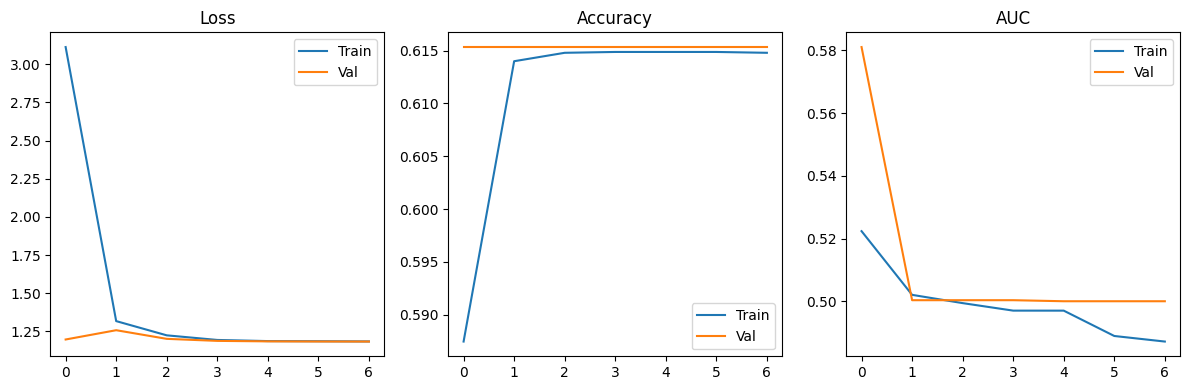

In [16]:
# =====================
# TESTING
# =====================
model.load_state_dict(torch.load(config["model_path_auc"]))
model.eval()
test_loss, test_preds, test_labels, test_probs = 0, [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        test_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_acc, test_prec, test_rec, test_f1, test_auc = compute_metrics(test_labels, test_preds, test_probs)

# Specificity (macro-averaged)
cm = confusion_matrix(test_labels, test_preds)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp + 1e-8))

print("\n=== Test Results ===")
print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, "
      f"Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}, Spec={specificity:.4f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

# =====================
# FINAL SUMMARY PLOT
# =====================
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history["train_auc"], label="Train")
plt.plot(history["val_auc"], label="Val")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.savefig("summary.png")
plt.show()